In [10]:
import warnings
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["figure.dpi"] = 110


DATA_DIR = "/content"
USERS_PATH = os.path.join(DATA_DIR, "users.csv")
TX_PATH = os.path.join(DATA_DIR, "transactions.csv")


def pick_column(df, candidates, case_insensitive=True):
    cols = list(df.columns)
    if case_insensitive:
        low_map = {c.lower(): c for c in cols}
        for cand in candidates:
            if cand is None:
                continue
            c = cand.lower()
            if c in low_map:
                return low_map[c]
        for col in cols:
            for cand in candidates:
                if cand is None:
                    continue
                if cand.lower() in col.lower():
                    return col
    else:
        for cand in candidates:
            if cand in df.columns:
                return cand
    return None

def to_numeric_money(s):
    if s is None:
        return None
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")
    return pd.to_numeric(
        s.astype(str)
         .str.replace(r"[\$€£₺,\s]", "", regex=True)
         .str.replace(".", ".", regex=False),
        errors="coerce"
    )


In [12]:
users = pd.read_csv(USERS_PATH, encoding="utf-8", engine="python")
tx = pd.read_csv(TX_PATH, encoding="utf-8", engine="python")

users.columns = [c.strip() for c in users.columns]
tx.columns = [c.strip() for c in tx.columns]

user_key_u = pick_column(users, ["User", "UserID", "User Id", "user_id", "CustomerID", "Customer Id"])
user_key_t = pick_column(tx, ["User", "UserID", "User Id", "user_id", "CustomerID", "Customer Id"])

if user_key_u is None or user_key_t is None:
    raise ValueError("Kullanıcı ID sütunu bulunamadı. Lütfen 'User' veya benzeri bir alan olduğundan emin olun.")

amount_col = pick_column(tx, ["Amount", "Transaction Amount", "Price", "Spending", "Total", "Value"])
if amount_col is None:
    raise ValueError("Harcama/Tutar sütunu bulunamadı. Lütfen 'Amount' veya benzeri alan olduğundan emin olun.")

city_col = pick_column(tx, ["Merchant City", "City", "MerchantCity", "Merchant City Name"])
time_col = pick_column(tx, ["Transaction Time", "Transaction Date", "Timestamp", "Time", "Date"])
gender_col = pick_column(users, ["Gender", "Sex"])
income_col = pick_column(users, ["Yearly Income - Person", "Yearly Income", "Income", "Annual Income", "Yearly_Income_Person"])

tx[amount_col] = to_numeric_money(tx[amount_col])

if time_col is not None:
    tx[time_col] = pd.to_datetime(tx[time_col], errors="coerce", infer_datetime_format=True)
    tx["Hour"] = tx[time_col].dt.hour
else:
    tx["Hour"] = np.nan

if income_col is not None:
    users["IncomeNumeric"] = to_numeric_money(users[income_col])
else:
    users["IncomeNumeric"] = np.nan

df = tx.merge(users, left_on=user_key_t, right_on=user_key_u, how="left", suffixes=("_tx", "_u"))

summary = {
    "transactions_rows": len(tx),
    "users_rows": len(users),
    "merged_rows": len(df),
    "amount_nulls": int(df[amount_col].isna().sum()),
    "time_nulls": int(df[time_col].isna().sum()) if time_col else None,
    "gender_nulls": int(df[gender_col].isna().sum()) if gender_col else None,
    "income_nulls": int(df["IncomeNumeric"].isna().sum())
}
display(pd.Series(summary, name="Data Quality Summary"))
display(df.head())


,Data Quality Summary
transactions_rows,19963
users_rows,2000
merged_rows,19963
amount_nulls,0
time_nulls,0
gender_nulls,0
income_nulls,0


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,IncomeNumeric
0,102,0,2002,9,1,2025-08-18 06:21:00,2.08,Swipe Transaction,3527213246127876953,La Verne,...,IL,60153,41.88,-87.84,$15451,$22158,$19101,681,5,22158
1,435,0,2002,9,1,2025-08-18 06:42:00,5.59,Swipe Transaction,-727612092139916043,Monterey Park,...,OH,44102,41.47,-81.67,$14737,$30049,$80474,700,1,30049
2,348,0,2002,9,2,2025-08-18 06:22:00,132.12,Swipe Transaction,-727612092139916043,Monterey Park,...,IL,60616,41.83,-87.68,$25365,$41793,$1141,730,5,41793
3,270,0,2002,9,2,2025-08-18 17:45:00,60.91,Swipe Transaction,3414527459579106770,Monterey Park,...,NY,14817,42.38,-76.39,$20159,$41106,$106963,762,3,41106
4,106,0,2002,9,3,2025-08-18 06:23:00,118.74,Swipe Transaction,5817218446178736267,La Verne,...,NC,27502,35.72,-78.84,$32485,$66230,$90248,742,3,66230


,TotalAmount
Merchant City,
La Verne,1045322.48
Monterey Park,283294.79
Mira Loma,228943.63
ONLINE,130398.07
Cancun,10768.53
Ontario,9425.28
Las Vegas,8493.74
Marlton,7197.77
Diamond Bar,6595.03


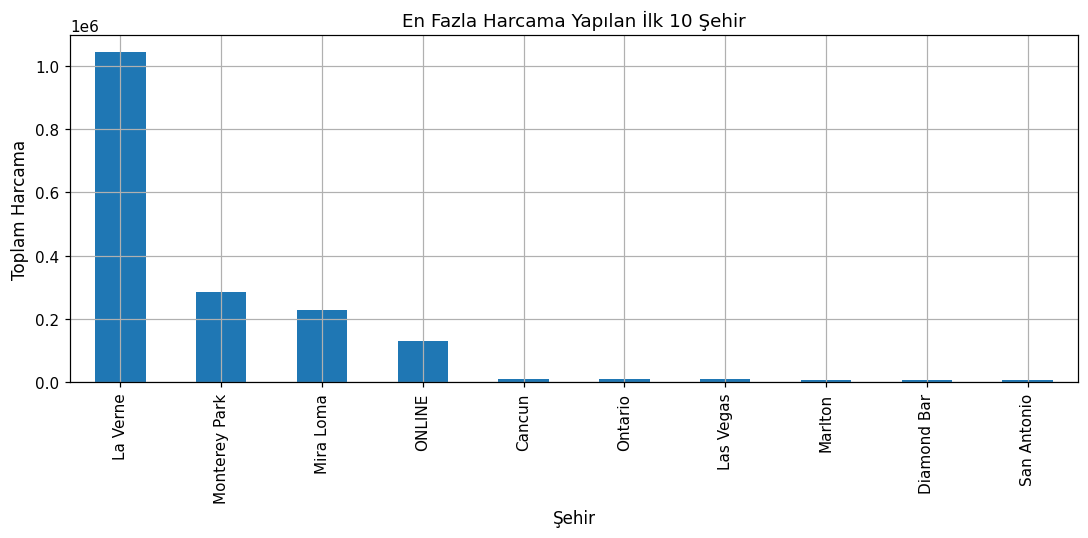

In [13]:
if city_col is None:
    print("Uyarı: Şehir sütunu bulunamadı, bu bölüm atlanıyor.")
else:
    city_agg = (
        df.groupby(city_col, dropna=False)[amount_col]
          .sum()
          .sort_values(ascending=False)
          .head(10)
    ).rename("TotalAmount")
    display(city_agg.to_frame())

    plt.figure()
    city_agg.plot(kind="bar")
    plt.title("En Fazla Harcama Yapılan İlk 10 Şehir")
    plt.xlabel("Şehir")
    plt.ylabel("Toplam Harcama")
    plt.tight_layout()
    plt.show()


,TotalAmount
Hour,
0,5001.90
1,1177.99
2,2042.49
3,2560.96
4,1753.44
5,72221.95
6,897523.69
7,55786.57
8,17614.61


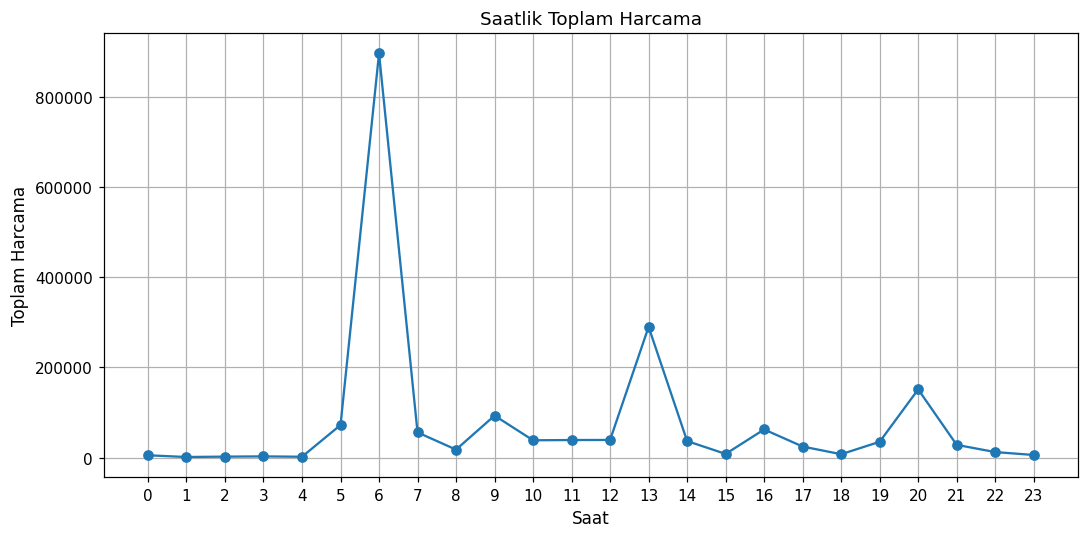

In [14]:
if "Hour" not in df.columns or df["Hour"].isna().all():
    print("Uyarı: Zaman/saat bilgisi bulunamadı, bu bölüm atlanıyor.")
else:
    hourly = (
        df.dropna(subset=["Hour"])
          .groupby("Hour")[amount_col]
          .sum()
          .reindex(range(24), fill_value=0)
    ).rename("TotalAmount")
    display(hourly.to_frame())

    plt.figure()
    plt.plot(hourly.index, hourly.values, marker="o")
    plt.title("Saatlik Toplam Harcama")
    plt.xlabel("Saat")
    plt.ylabel("Toplam Harcama")
    plt.xticks(range(0,24,1))
    plt.tight_layout()
    plt.show()


,TotalAmount
Gender,
Female,984753.45
Male,941525.36


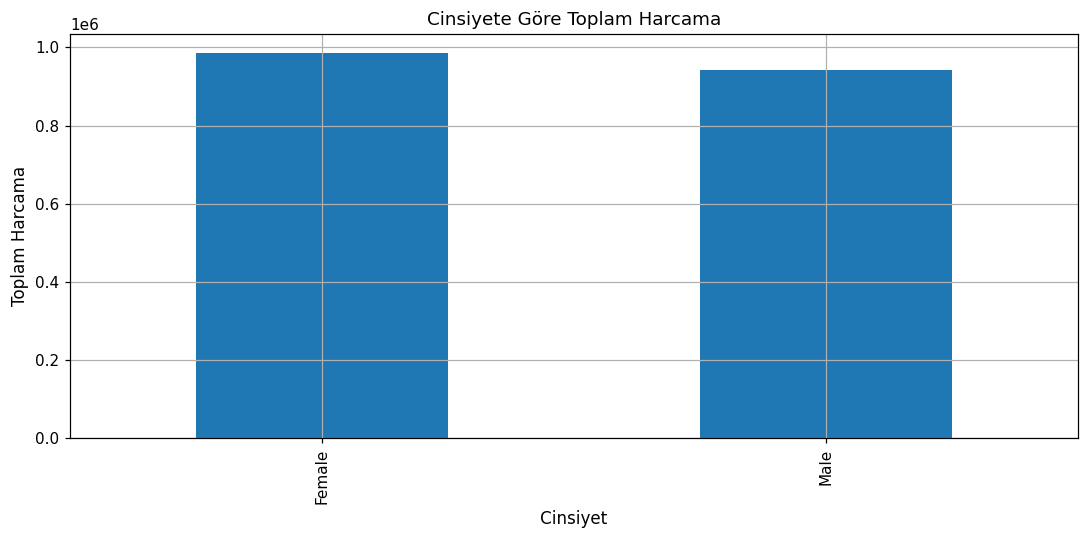

In [15]:
if gender_col is None:
    print("Uyarı: Cinsiyet sütunu bulunamadı, bu bölüm atlanıyor.")
else:
    gender_agg = (
        df.groupby(gender_col, dropna=False)[amount_col]
          .sum()
          .sort_values(ascending=False)
    ).rename("TotalAmount")
    display(gender_agg.to_frame())

    plt.figure()
    gender_agg.plot(kind="bar")
    plt.title("Cinsiyete Göre Toplam Harcama")
    plt.xlabel("Cinsiyet")
    plt.ylabel("Toplam Harcama")
    plt.tight_layout()
    plt.show()


,User,TotalSpend,IncomeNumeric
0,0,4140.96,59696
1,1,3359.81,77254
2,2,3367.61,33483
3,3,2636.14,249925
4,4,3782.87,109687


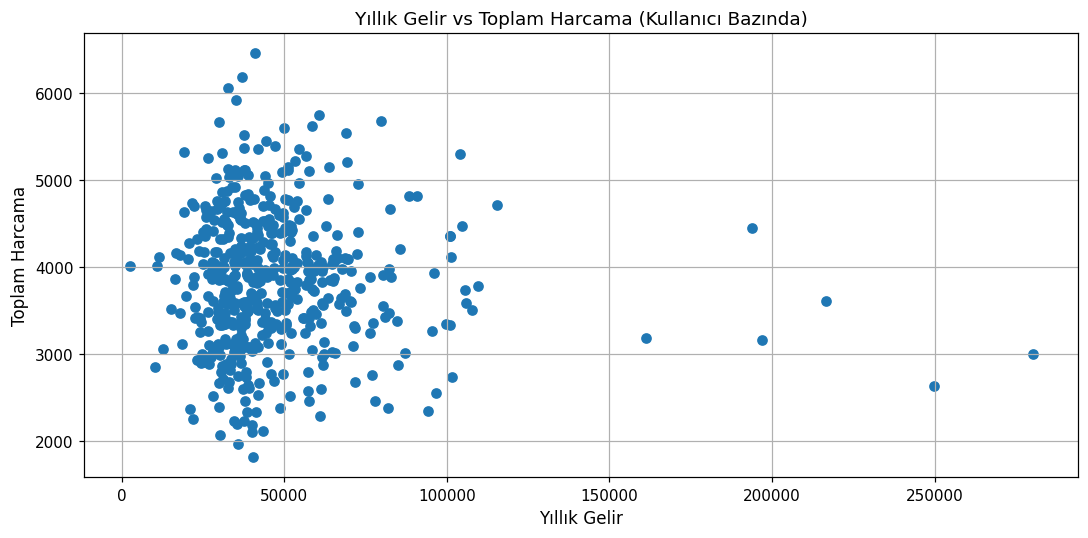

Korelasyon (Gelir vs Harcama): -0.054


In [16]:
user_spend = (
    df.groupby(user_key_t, dropna=False)[amount_col]
      .sum()
      .rename("TotalSpend")
      .to_frame()
)

incomes = users[[user_key_u, "IncomeNumeric"]].copy()

spend_income = user_spend.merge(incomes, left_on=user_key_t, right_on=user_key_u, how="left")
clean_si = spend_income.dropna(subset=["IncomeNumeric", "TotalSpend"]).copy()

display(clean_si.head())

if not clean_si.empty:
    plt.figure()
    plt.scatter(clean_si["IncomeNumeric"], clean_si["TotalSpend"])
    plt.title("Yıllık Gelir vs Toplam Harcama (Kullanıcı Bazında)")
    plt.xlabel("Yıllık Gelir")
    plt.ylabel("Toplam Harcama")
    plt.tight_layout()
    plt.show()

    corr = clean_si["IncomeNumeric"].corr(clean_si["TotalSpend"])
    print(f"Korelasyon (Gelir vs Harcama): {corr:.3f}")
else:
    print("Uyarı: Gelir ve harcama verileri eşleştirilemedi veya eksik.")


In [17]:
insights = {}

if 'city_col' in locals() and city_col is not None:
    city_total = df.groupby(city_col, dropna=False)[amount_col].sum().sort_values(ascending=False)
    if not city_total.empty:
        top_city, top_city_val = city_total.index[0], city_total.iloc[0]
        insights["Top City"] = (top_city, float(top_city_val))

if "Hour" in df.columns and not df["Hour"].isna().all():
    hourly_total = df.dropna(subset=["Hour"]).groupby("Hour")[amount_col].sum().sort_values(ascending=False)
    if not hourly_total.empty:
        top_hour, top_hour_val = int(hourly_total.index[0]), float(hourly_total.iloc[0])
        insights["Top Hour"] = (top_hour, top_hour_val)

if 'gender_col' in locals() and gender_col is not None:
    gender_total = df.groupby(gender_col, dropna=False)[amount_col].sum().sort_values(ascending=False)
    if not gender_total.empty:
        top_gender, top_gender_val = gender_total.index[0], float(gender_total.iloc[0])
        insights["Top Gender"] = (top_gender, top_gender_val)

if "IncomeNumeric" in users.columns and users["IncomeNumeric"].notna().any():
    user_total = df.groupby(user_key_t)[amount_col].sum().rename("TotalSpend")
    income_map = users.set_index(user_key_u)["IncomeNumeric"]
    tmp = pd.concat([user_total, income_map], axis=1).dropna()
    if not tmp.empty:
        tmp["IncomeQuartile"] = pd.qcut(tmp["IncomeNumeric"], 4, labels=["Q1 (Düşük)", "Q2", "Q3", "Q4 (Yüksek)"])
        quartile_avg = tmp.groupby("IncomeQuartile")["TotalSpend"].mean().sort_values(ascending=False)
        insights["Top Income Quartile by Avg Spend"] = quartile_avg.index[0]

print("=== Özet Çıkarımlar ===")
for k, v in insights.items():
    print(f"- {k}: {v}")

print("\n=== Kısa Yorumlar ===")
if "Top City" in insights:
    print(f"* En fazla harcama yapılan şehir: **{insights['Top City'][0]}** (Toplam: {insights['Top City'][1]:,.0f}).")
else:
    print("* Şehir bazlı analiz için gerekli sütun bulunamadı veya veri yetersiz.")

if "Top Hour" in insights:
    print(f"* Harcamanın en yoğun olduğu saat dilimi: **{insights['Top Hour'][0]}:00** civarı (Toplam: {insights['Top Hour'][1]:,.0f}).")
else:
    print("* Saat bazlı analiz için zaman kolonu eksik veya çözümlenemedi.")

if "Top Gender" in insights:
    print(f"* Cinsiyet kırılımında toplam harcama lideri: **{insights['Top Gender'][0]}**.")
else:
    print("* Cinsiyet kırılımı için gerekli sütun bulunamadı.")

if "Top Income Quartile by Avg Spend" in insights:
    print(f"* Ortalama harcama açısından en yüksek gelir grubu: **{insights['Top Income Quartile by Avg Spend']}**.")
else:
    print("* Gelir-harcama ilişkisi için yeterli eşleşmiş veri yok.")


=== Özet Çıkarımlar ===
- Top City: ('La Verne', 1045322.48)
- Top Hour: (6, 897523.69)
- Top Gender: ('Female', 984753.45)
- Top Income Quartile by Avg Spend: Q3

=== Kısa Yorumlar ===
* En fazla harcama yapılan şehir: **La Verne** (Toplam: 1,045,322).
* Harcamanın en yoğun olduğu saat dilimi: **6:00** civarı (Toplam: 897,524).
* Cinsiyet kırılımında toplam harcama lideri: **Female**.
* Ortalama harcama açısından en yüksek gelir grubu: **Q3**.


,Count
PayMethod,
Swipe Transaction,15840
Chip,2808
Online Transaction,1315


,TotalAmount
PayMethod,
Swipe Transaction,1528674.00
Chip,267272.11
Online Transaction,130332.70


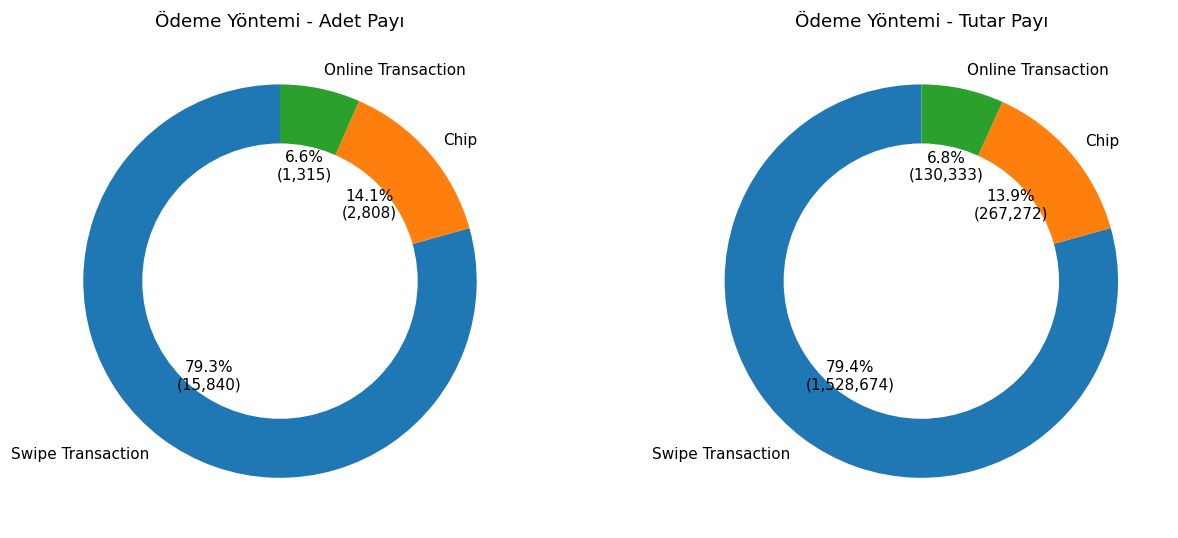

In [18]:
use_chip_col = pick_column(df, ["Use Chip", "UseChip", "Chip", "is_chip", "Is Chip"])

if use_chip_col is None:
    print("Uyarı: 'Use Chip' benzeri bir sütun bulunamadı, bölüm atlandı.")
else:
    tmp = df[[use_chip_col, amount_col]].copy()

    def _normalize_chip(v):
        if pd.isna(v):
            return "Unknown"
        s = str(v).strip().lower()
        if s in {"y", "yes", "true", "1"}:
            return "Chip"
        if s in {"n", "no", "false", "0"}:
            return "Swipe"

        if "chip" in s:
            return "Chip"
        return s.title() if s else "Unknown"

    tmp["PayMethod"] = tmp[use_chip_col].map(_normalize_chip)

    count_s = tmp.groupby("PayMethod")[amount_col].size().rename("Count").sort_values(ascending=False)
    amount_s = tmp.groupby("PayMethod")[amount_col].sum().rename("TotalAmount").sort_values(ascending=False)

    display(count_s.to_frame())
    display(amount_s.to_frame())

    import matplotlib.pyplot as plt

    def autopct_format(values):
        def _inner(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return f"{pct:.1f}%\n({val:,})"
        return _inner

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    wedges1, texts1, autotexts1 = axes[0].pie(
        count_s.values, labels=count_s.index, autopct=autopct_format(count_s.values), startangle=90
    )
    centre_circle1 = plt.Circle((0,0),0.70,fc='white')
    axes[0].add_artist(centre_circle1)
    axes[0].set_title("Ödeme Yöntemi - Adet Payı")

    wedges2, texts2, autotexts2 = axes[1].pie(
        amount_s.values, labels=amount_s.index, autopct=autopct_format(amount_s.values), startangle=90
    )
    centre_circle2 = plt.Circle((0,0),0.70,fc='white')
    axes[1].add_artist(centre_circle2)
    axes[1].set_title("Ödeme Yöntemi - Tutar Payı")

    plt.tight_layout()
    plt.show()
